# ACA centroiding/ Dynamic Background/ Validations#

In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
from chandra_aca import transform
from importlib import reload
import sys

In [2]:
sys.path.append("../py")
#local imports
import classes
from classes import *
import sim_aca_l0 as siml0
import centroids as cntr
import myplot as mplt

### Contents ###

* Simulate <code>IMGROW0</code>, <code>IMGCOL0</code> response to dither.


* Simulate two stars, with magnitudes of 8.2 mag and 10.2 mag, and __no hot pixels__, using all three background prescriptions <code>(FlightBgd, DynamBgd_Median, SynamBgd_SigmaClip).</code>

### <code>IMGROW0</code>, <code>IMGCOL0</code> response to dither###

__Note 1.__ This is relevant only for simulations. Some prescription of dither needs to be introduced in order to move around the ACA image window and simulate the on-the-fly dynamic background construction and centroiding. For the real data, <code>IMGROW0</code>, <code>IMGCOL0</code> are read from the <code>aca_l0</code> file.

__Note 2.__ In reality, this response depends likely on the next anticipated centroid position because <code>IMGROW0</code>, <code>IMGCOL0</code> time behaviour differs among the slots.

Simulated <code>IMGROW0</code> and <code>IMGCOL0</code> are defined so that they respond to the dither pathern (yaw, pitch). Here this response is defined so that the difference between <code>yaw/(5 arcsec/pixel)</code> and <code>IMGROW0</code>, and <code>pitch/(5 arcsec/pixel)</code> and <code>IMGCOL0</code> is always < 1 pixel to keep star image near the center of the 8x8 window.

Below, this algorithm is checked against ACIS data (obsID 50804).

In [3]:
obsid = 50804
slot = 3
dwell = events.dwells.filter(obsid=obsid)[0]
slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
time = slot_data['TIME']
imgrow0 = slot_data['IMGROW0']
imgcol0 = slot_data['IMGCOL0']

In [4]:
# Dither parameters, ACIS
ampl_yaw = 8. * u.arcsec
ampl_pitch = 8. * u.arcsec
pxsize = 5. * u.arcsec # per pixel
period_yaw = 1000.0 # sec
period_pitch = 707.1 # sec

# "Fit" parameters (depend on obsid and slot)
phase_yaw = 0.9 # in 2 pi
phase_pitch = 0.75 # in 2 pi
delta = 0.25 # px

yaw = ampl_yaw * np.sin(2 * np.pi * time / period_yaw + 2 * np.pi * phase_yaw)
pitch = ampl_pitch * np.sin(2 * np.pi * time / period_pitch + 2 * np.pi * phase_pitch)

row_drift = yaw / pxsize
col_drift = pitch / pxsize

sim_row0 = np.array(np.round(row_drift - delta), dtype=np.int)
sim_col0 = np.array(np.round(col_drift - delta), dtype=np.int)

print(np.sum(row_drift - sim_row0 > 1), np.sum(col_drift - sim_col0 > 1))

0 0


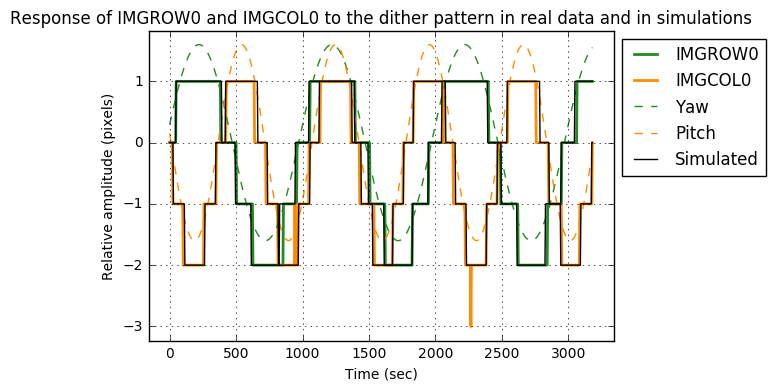

In [5]:
#plt.figure(figsize=(14, 6))

plt.plot(time - time[0], imgrow0 - imgrow0[0], 'forestgreen', lw=2, label='IMGROW0')
plt.plot(time - time[0], imgcol0 - imgcol0[0], 'darkorange', lw=2, label='IMGCOL0')
plt.plot(time - time[0], row_drift, 'forestgreen', ls='--', label='Yaw')
plt.plot(time - time[0], col_drift, 'darkorange', ls='--', label='Pitch')

plt.plot(time - time[0], sim_row0, 'k')
plt.plot(time - time[0], sim_col0, 'k', label='Simulated')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel("Time (sec)")
plt.ylabel("Relative amplitude (pixels)")
plt.title('Response of IMGROW0 and IMGCOL0 to the dither pattern in real data and in simulations');
plt.margins(0.05)
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));

### No hot pixels ###

Simulate two stars, with magnitudes of 8.2 mag and 10.2 mag, and __no hot pixels__, using all three background prescriptions <code>(FlightBgd, DynamBgd_Median, DynamBgd_SigmaClip)</code>. Confirm that dynamic background computations are consistent with the flight background algorithm.

In [6]:
img_size = 8 # pixels
delta_t = 4.1 # sec
integ = 1.696 # sec
nframes = 500 # number of time frames

In [7]:
# Define dither parameters
ampl, period = siml0.dither_acis()
phase_yaw = 0.9 # in 2 pi
phase_pitch = 0.75 # in 2 pi
phase = [phase_yaw, phase_pitch] # in 2 * np.pi
delta = 0.25 # px

In [8]:
# Average background amd kwargs for simulated aca_l0 data
bgdavg = 10. # pixel value
sim_kwargs = {'nframes':nframes, 'delta_t':delta_t, 'integ':integ, 'bgdavg':bgdavg,
              'ampl':ampl, 'period':period, 'phase':phase, 'delta':delta}
# Example 2: with hot pixel sampled only after the first t = 500sec
# kwargs['phase'] = 0.

In [9]:
ndeque = 5 # number of stored pixel values
slot = 0

In [10]:
mags = [10.2, 8.2] # mag

bgd_kwargs = [{}, {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque},
                   {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque}]

rows_all = []

for mag in mags:
    
    sim_kwargs['mag'] = mag
    
    np.random.seed(42)
    slot_data, true_centroids = siml0.simulate_aca_l0(img_size, hot_pixels=None, **sim_kwargs)
    
    for i, Bgd_Class in enumerate([FlightBgd, DynamBgd_Median, DynamBgd_SigmaClip]):
        bgd_object = Bgd_Class(**bgd_kwargs[i]) 
        rows = cntr.centroids(slot, slot_data, img_size, bgd_object, nframes=nframes)
        for row in rows:
            row['mag'] = mag
            row['bgd_class_name'] = bgd_object.__class__.__name__
            row['true_row'] = true_centroids[0]
            row['true_col'] = true_centroids[1]
            y_pixels = true_centroids[0] + row['row0']
            z_pixels = true_centroids[1] + row['col0']
            true_yanzan = transform.pixels_to_yagzag(y_pixels, z_pixels)
            row['true_yan'] = true_yanzan[0]
            row['true_zan'] = true_yanzan[1]
            if isinstance(bgd_object, (DynamBgd_Median, DynamBgd_SigmaClip)):
                row['ndeque'] = bgd_kwargs[i]['ndeque']
            else:
                row['ndeque'] = None
            rows_all.append(row)
        
t = Table(rows_all)

In [11]:
print(t.colnames)
print()
print(t['bgd_class_name', 'mag', 'ndeque'])
print()

['bgd_class_name', 'bgdimg', 'col', 'col0', 'deque_dict', 'img', 'imgraw', 'mag', 'ndeque', 'row', 'row0', 'slot', 'time', 'true_col', 'true_row', 'true_yan', 'true_zan', 'yan', 'zan']

  bgd_class_name   mag  ndeque
------------------ ---- ------
         FlightBgd 10.2   None
   DynamBgd_Median 10.2      5
DynamBgd_SigmaClip 10.2      5
         FlightBgd  8.2   None
   DynamBgd_Median  8.2      5
DynamBgd_SigmaClip  8.2      5



In [12]:
# 'Dither' check
row_drift, col_drift = siml0.get_rowcol_drift(t['time'][0], ampl=ampl, period=period, phase=phase)

imgrow0 = np.array(np.round(row_drift + delta), dtype=np.int)
imgcol0 = np.array(np.round(col_drift + delta), dtype=np.int)

print(np.sum(row_drift - imgrow0 > 1), np.sum(col_drift - imgcol0 > 1))

0 0


### Visualisation of the results ###

* Derived vs. 'true' coordinates

* Difference between derived and 'true' coordinates

* Residuals

* Background images

__Plot derived and 'true' coordinates__

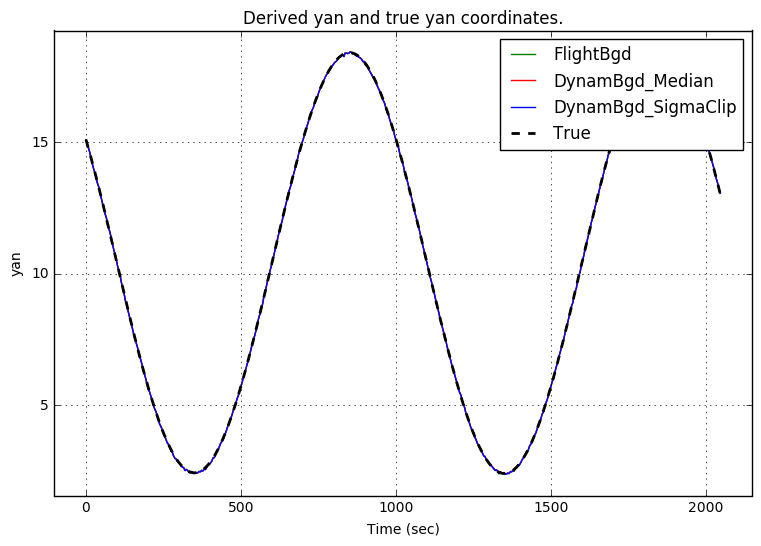

In [13]:
#mplt.plot_coords(slot, t, 'row') # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t, 'yan') # computed 'yan' coordinate

__Plot difference between computed and 'true' coordinates__

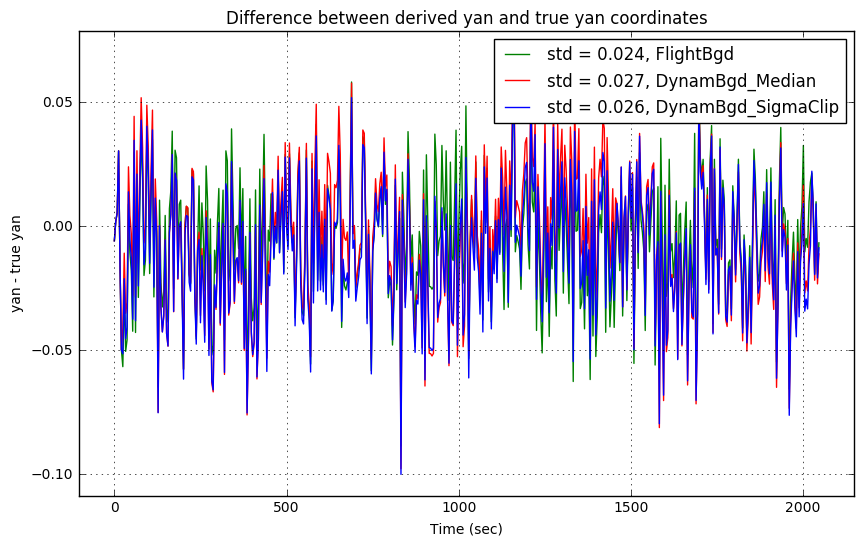

In [14]:
#mplt.plot_coords_excess(slot, t, 'row')
mplt.plot_coords_excess(slot, t, 'yan')

__Plot residuals (Bright - Faint star)__

Bright - Faint star


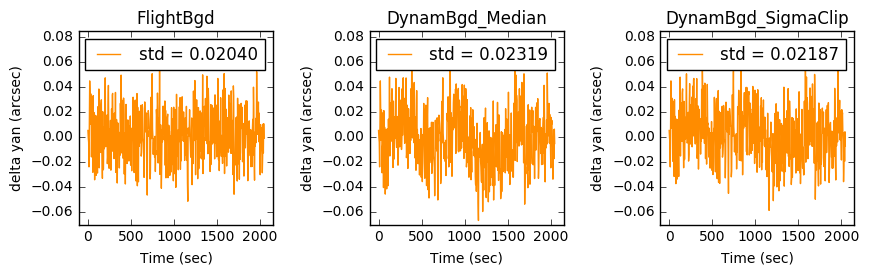

In [15]:
faint = t['mag'] == 10.2
bright = t['mag'] == 8.2

key = 'yan'

fig = plt.figure(figsize=(10, 2.5))

ylim = (-0.07, 0.085)

bgd_class_names = ['FlightBgd', 'DynamBgd_Median', 'DynamBgd_SigmaClip']

for i, bgd_class_name in enumerate(bgd_class_names):
    plt.subplot(1, 3, i + 1)
    d_ang = t[bright][key][i] - t[faint][key][i]
    plt.plot(t['time'][0], d_ang, color='Darkorange',
             label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
    plt.title(bgd_class_name)
    plt.xlabel('Time (sec)')
    plt.ylabel('delta {} (arcsec)'.format(key))
    plt.legend()
    plt.margins(0.05)
    plt.ylim(ylim)
    
plt.subplots_adjust(wspace=0.5)
print("Bright - Faint star")

__Plot derived background images__

* <span style="color:black;font-weight:bold">Black patch</span> - CCD region that will eventually be sampled due to the dither
* <span style="color:crimson;font-weight:bold">8x8 patch</span> - 8x8 pixel region corresponding to background derived for a current frame (sampled edge pixels + average background value for pixels inside the edge)

Format of the titles is 'time: imgrow0, imgcol0'
Plot bgdimg from 0 to 7
Bgd Class: DynamBgd_Median, ndeque = 5


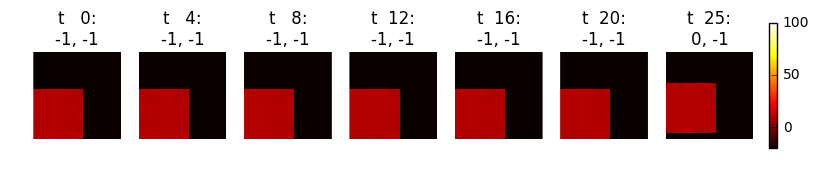

In [16]:
data = mplt.plot_images(t, n_start=0, n_stop=7, slot=0, mag=mags[0],
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-20, vmax=100)

* <span style="color:black;font-weight:bold">Black patch</span> - CCD region that will eventually be sampled due to the dither
* <span style="color:crimson;font-weight:bold">Red patch</span> - pixels that were among the edge pixels (i.e. were sampled) at least once until 'now'

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 0 to 7
Bgd Class: DynamBgd_Median, ndeque = 5


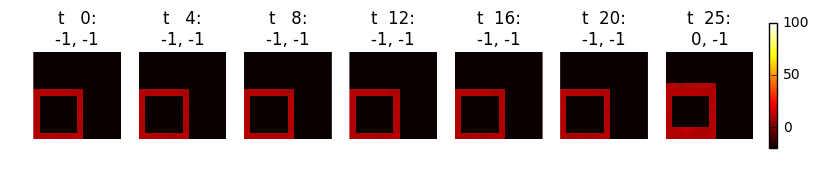

In [17]:
data = mplt.plot_bgd_patches(t, slot=0, mag=mags[0], n_start=0, n_stop=7,
                             img_size=img_size, bgd_class_name='DynamBgd_Median',
                             vmin=-20, vmax=100)

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 200 to 207
Bgd Class: DynamBgd_Median, ndeque = 5


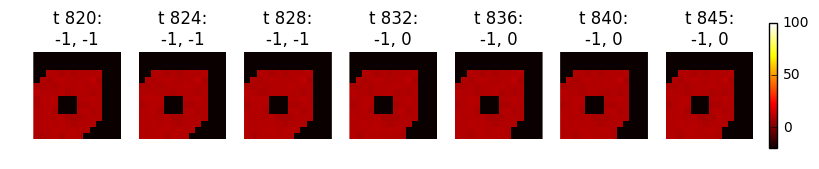

In [18]:
data = mplt.plot_bgd_patches(t, slot=0, mag=mags[0], n_start=200, n_stop=207,
                             img_size=img_size, bgd_class_name='DynamBgd_Median',
                             vmin=-20, vmax=100)

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 493 to 500
Bgd Class: DynamBgd_Median, ndeque = 5


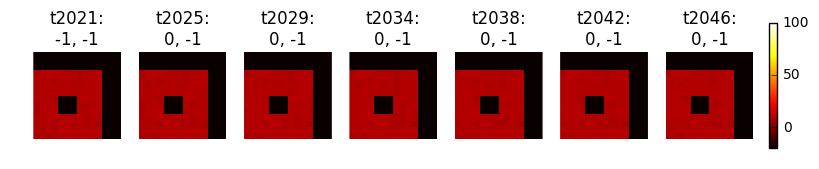

In [19]:
n_start = nframes - 7
data = mplt.plot_bgd_patches(t, slot=0, mag=mags[0], n_start=n_start, n_stop=nframes,
                             img_size=img_size, bgd_class_name='DynamBgd_Median',
                             vmin=-20, vmax=100)

In [20]:
ok = t['bgd_class_name'] == 'DynamBgd_Median'
ok1 = t['slot'] == 0
lens = []

for key, val in t[ok * ok1]['deque_dict'][0][-1].items():
    lens.append(len(val))
    
print("Min deque length = {}, Max deque length = {}".format(np.min(lens), np.max(lens)))

Min deque length = 5, Max deque length = 5
